# Import Key Libraries

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

# Data Cleaning

In [261]:
# Load dataset

df = pd.read_csv("df_all_rounds.csv")

### Zip Code

In [262]:
# Create a column for zip code

df['zip_code'] = [url[url.find("VT")+3:url.find("VT")+8] for url in df['link']]

In [263]:
# Drop links column

df = df.drop(['link'], axis = 1)

### View Description

In [264]:
# Regroup view description so all "Mountain(s)" become "Mountain"

df['view_description'].unique()

array(['{}', ' Mountain(s)', ' Mountain(s), Water', ' Water', ' Mountain'],
      dtype=object)

In [265]:
df['view_description'] = [view.replace("Mountain(s)","Mountain") for view in df['view_description']]
df['view_description'].unique()

array(['{}', ' Mountain', ' Mountain, Water', ' Water'], dtype=object)

### Lot Size

In [266]:
# Drop where lot size column includes a price per year (a few HOA fees are here)

df = df.drop(df[df.lot_size.str.contains(r'[$]')].index)

In [267]:
# Take acres out of lot size 

df['lot_size'] = [lot.split(" ")[0] for lot in df['lot_size']]
df['lot_size'] = [lot.replace(",","") for lot in df['lot_size']]

In [268]:
# Convert to float 64

df['lot_size'] = pd.to_numeric(df['lot_size'],errors='coerce')

### Home Square Footage

In [269]:
# Take sqft out of square footage

df['sf'] = [footage.split(" ")[0] for footage in df['sf']]
df['sf'] = [footage.replace(",","") for footage in df['sf']]

In [270]:
# Convert to float 64

df['sf'] = pd.to_numeric(df['sf'],errors='coerce')

### Bathrooms

In [271]:
# Take ba out of bathrooms

df['bathrooms'] = [bathroom.split(" ")[0] for bathroom in df['bathrooms']]

In [272]:
# Convert to float 64

df['bathrooms'] = pd.to_numeric(df['bathrooms'],errors='coerce')

### Home Price

In [273]:
# Take dollar signs out of price

df['price'] = [value.split("$")[1] for value in df['price']]
df['price'] = [value.replace(",","") for value in df['price']]

In [274]:
# Convert to float 64

df['price'] = pd.to_numeric(df['price'],errors='coerce')

In [275]:
df.columns

Index(['Unnamed: 0', 'price', 'bedrooms', 'bathrooms', 'sf', 'year_built',
       'lot_size', 'view_description', 'on_waterfront', 'house_style',
       'new_construction', 'garage_spaces', 'zip_code'],
      dtype='object')

In [276]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [277]:
df.head()

,price,bedrooms,bathrooms,sf,year_built,lot_size,view_description,on_waterfront,house_style,new_construction,garage_spaces,zip_code
0,84900,2,2.0,902.0,1960,400752.0,{},{},Ranch,No,1,05045
1,335000,2,2.0,1680.0,1986,304920.0,{},{},Cape,No,0,05677
3,245000,3,2.0,1268.0,1960,174240.0,{},{},Cape,No,0,05730
4,374000,9,9.0,5788.0,1861,56628.0,{},{},Victorian,No,2,05143
5,360000,3,2.0,1804.0,1962,18295.0,{},{},Raised Ranch,No,2,05482


### Year Built

In [278]:
# Convert to float 64
df['year_built'] = pd.to_numeric(df['year_built'],errors='coerce')
# Drop rows where equal to zero

### Waterfront

In [279]:
df['on_waterfront'] = [value.replace("{}","No") for value in df['on_waterfront']]

### Drop NaNs and null values

In [280]:
df.dropna(inplace=True)

In [281]:
# Removing zero from year

df = df.loc[(df[['year_built']] != 0).all(axis=1)]

In [282]:
df.shape

(729, 12)

### Add Median Income from Vermont HUD

In [283]:
# Read county zip code data
df_county_zips = pd.read_csv('County_Zip_Codes.csv')
df_county_zips.columns

Index(['Zip Codes, Cities, and Counties in Vermont', 'Zip_Code', 'Unnamed: 2'], dtype='object')

In [284]:
df_county_zips = df_county_zips.drop(['Zip_Code'], axis = 1)
df_county_zips = df_county_zips.drop(['Unnamed: 2'], axis = 1)

In [285]:
# Create a column with county name only and a column with zip code only

df_county_zips['zip_code'] = [value.split(",")[0] for value in df_county_zips['Zip Codes, Cities, and Counties in Vermont']]
df_county_zips['county'] = [value.rsplit(',', 1)[1] for value in df_county_zips['Zip Codes, Cities, and Counties in Vermont']]
df_county_zips = df_county_zips.drop(['Zip Codes, Cities, and Counties in Vermont'], axis = 1)
df_county_zips['county'] = df_county_zips['county'].str.strip()
df_county_zips.head()

,zip_code,county
0,05001,Windsor
1,05009,Windsor
2,05030,Windsor
3,05031,Windsor
4,05032,Windsor


In [286]:
# Read county median income data

df_income = pd.read_csv("median_income.csv")
df_income = df_income.drop(['Unnamed: 2'], axis = 1)
df_income = df_income.drop(['Unnamed: 3'], axis = 1)

In [287]:
# Remove dollar signs and commas

df_income['Median_Income'] = [value.split("$")[1] for value in df_income['Median Income']]
df_income['Median_Income'] = [value.replace(",","") for value in df_income['Median_Income']]
df_income = df_income.drop(['Median Income'], axis = 1)
df_income = df_income.rename(columns={"County":"county"})
df_county_zips

,zip_code,county
0,05001,Windsor
1,05009,Windsor
2,05030,Windsor
3,05031,Windsor
4,05032,Windsor
...,...,...
304,05903,Essex
305,05904,Essex
306,05905,Essex
307,05906,Essex


In [288]:
df_county_zips.to_csv('df_county_zips.csv', index = False)
df_income.to_csv('df_income.csv', index = False)

In [289]:
# Formatting problems - was forced to merge outside of jupyter - merged dataset beleow

df_agg_income = pd.read_csv("df_agg_income.csv")

In [290]:
df_agg_income.dtypes

zip_code          int64
county           object
median_income     int64
dtype: object

# Exploratory Work

In [291]:
df.head()

,price,bedrooms,bathrooms,sf,year_built,lot_size,view_description,on_waterfront,house_style,new_construction,garage_spaces,zip_code
0,84900,2,2.0,902.0,1960.0,400752.0,{},No,Ranch,No,1,05045
1,335000,2,2.0,1680.0,1986.0,304920.0,{},No,Cape,No,0,05677
3,245000,3,2.0,1268.0,1960.0,174240.0,{},No,Cape,No,0,05730
4,374000,9,9.0,5788.0,1861.0,56628.0,{},No,Victorian,No,2,05143
5,360000,3,2.0,1804.0,1962.0,18295.0,{},No,Raised Ranch,No,2,05482


In [292]:
df.corr()

,price,bedrooms,bathrooms,sf,year_built,lot_size,garage_spaces
price,1.000000,0.295404,0.531818,0.702748,0.101296,0.315941,0.276560
bedrooms,0.295404,1.000000,0.709588,0.605379,-0.226979,0.110349,0.338864
bathrooms,0.531818,0.709588,1.000000,0.814085,-0.011695,0.146997,0.447119
sf,0.702748,0.605379,0.814085,1.000000,-0.011003,0.252858,0.430629
year_built,0.101296,-0.226979,-0.011695,-0.011003,1.000000,-0.005619,0.020644
lot_size,0.315941,0.110349,0.146997,0.252858,-0.005619,1.000000,0.142634
garage_spaces,0.276560,0.338864,0.447119,0.430629,0.020644,0.142634,1.000000


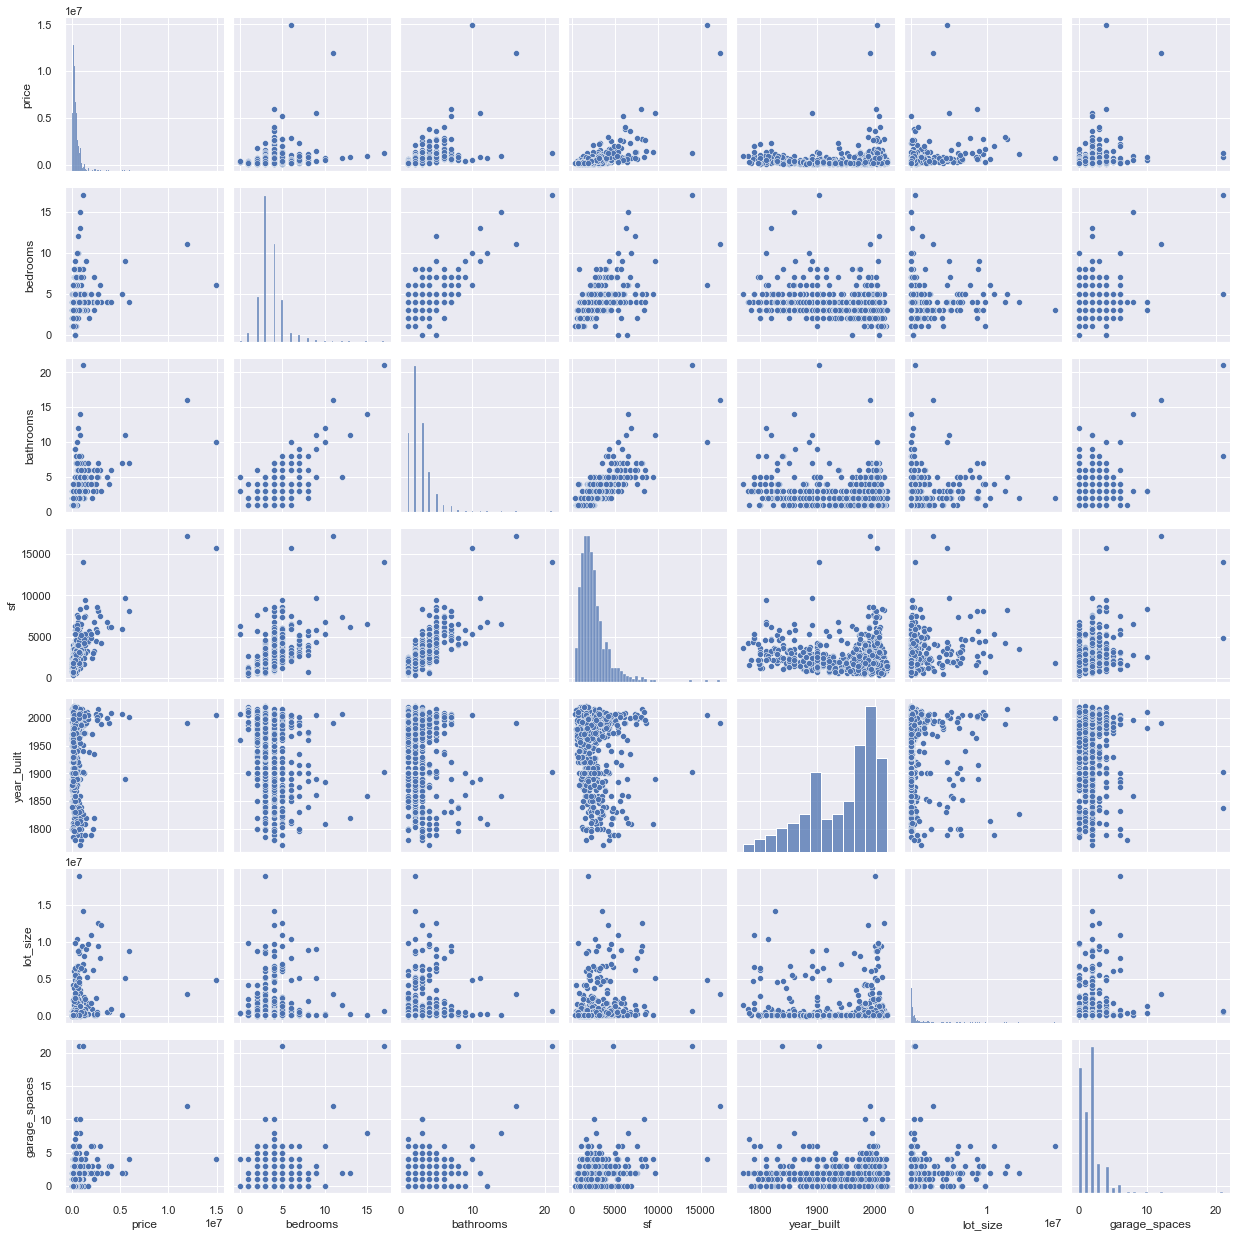

In [293]:
sns.pairplot(df)

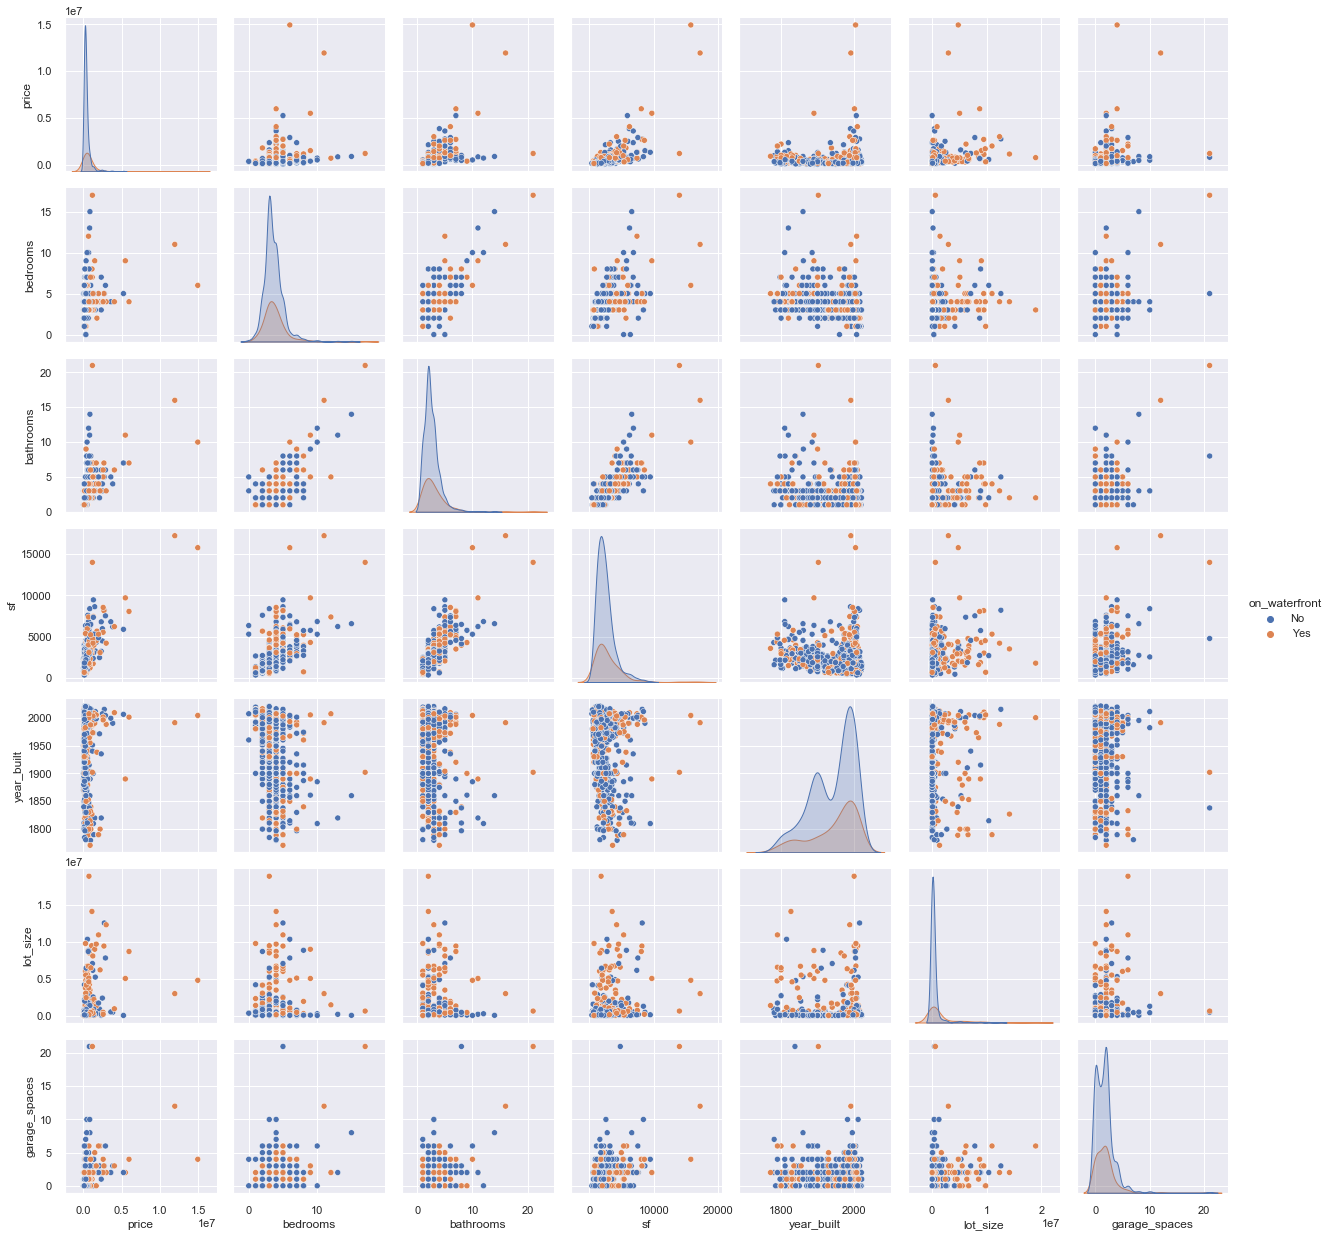

In [294]:
sns.pairplot(df, hue = 'on_waterfront')

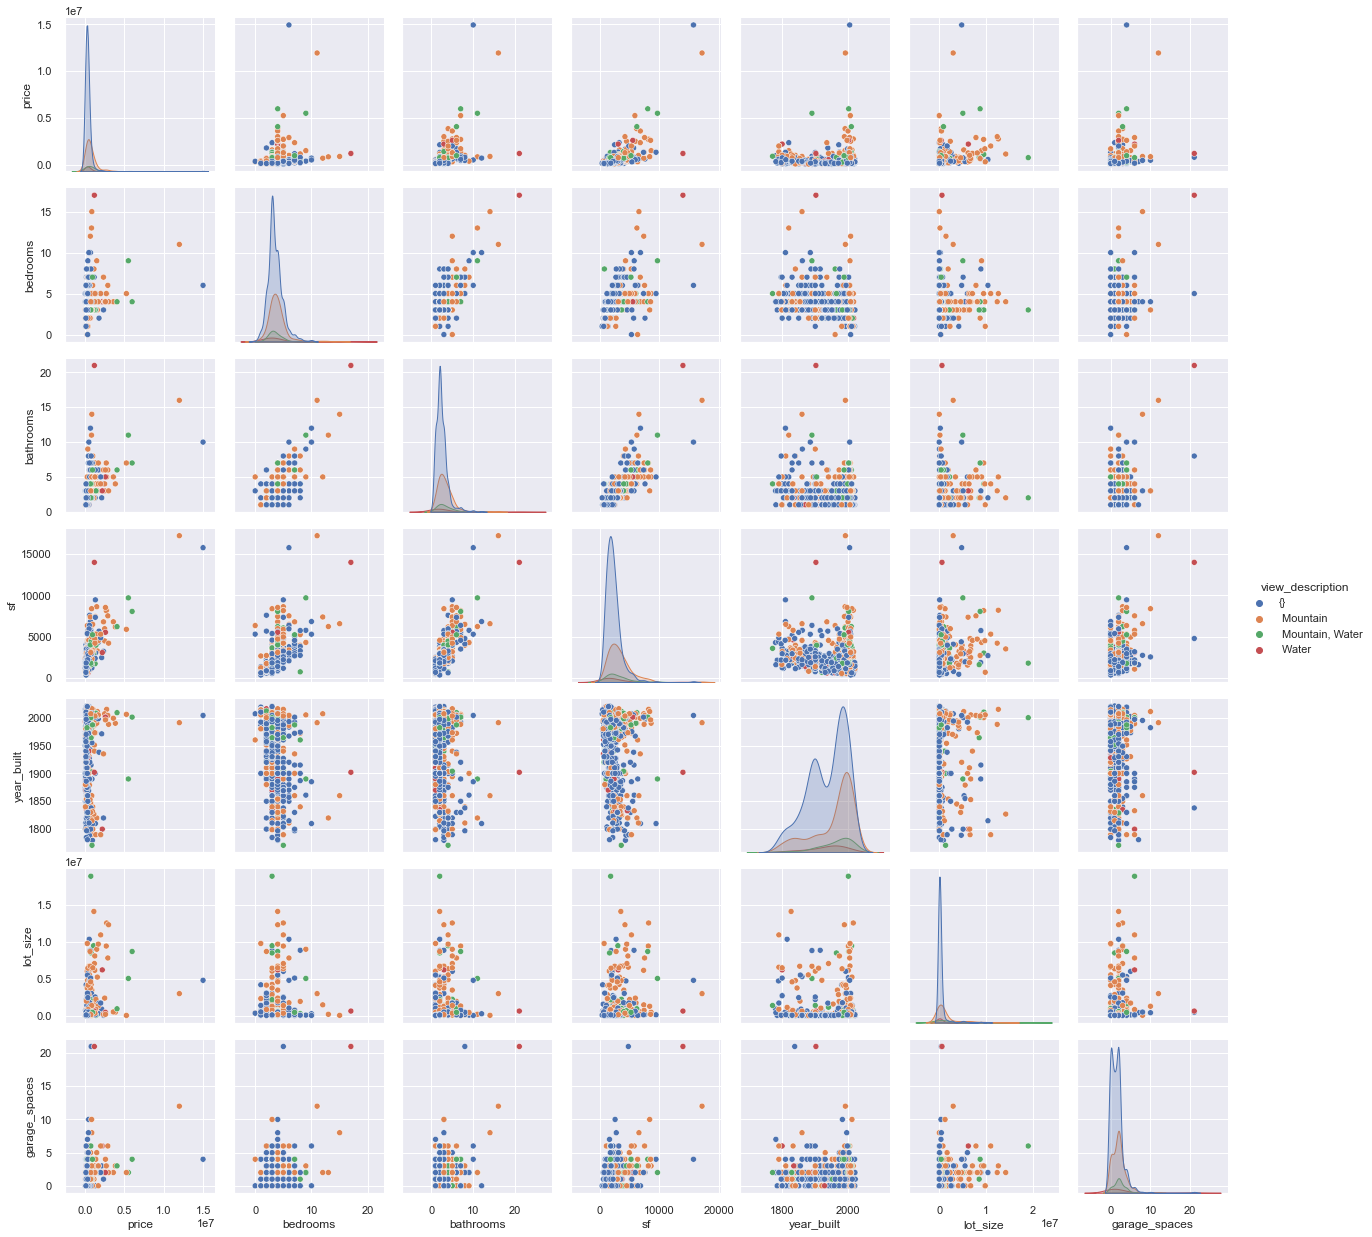

In [295]:
sns.pairplot(df, hue = 'view_description')

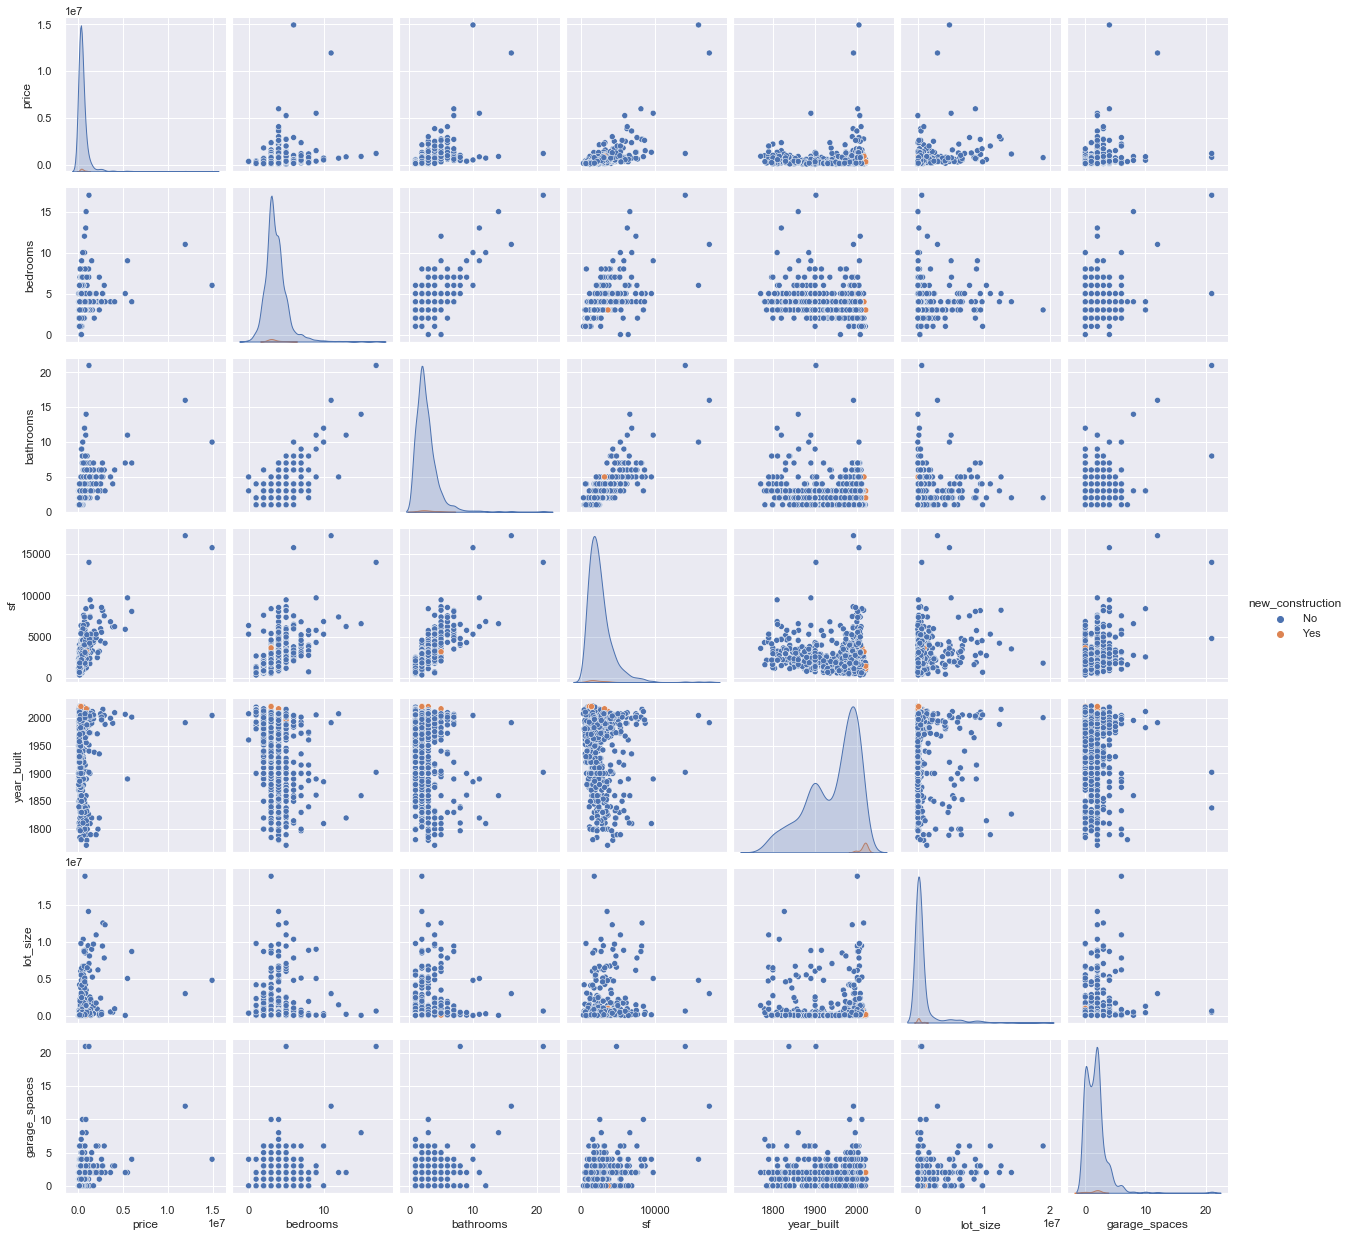

In [296]:
sns.pairplot(df, hue = 'new_construction')

### Determining Categorical Variable Impact on price

<Figure size 1440x720 with 0 Axes>

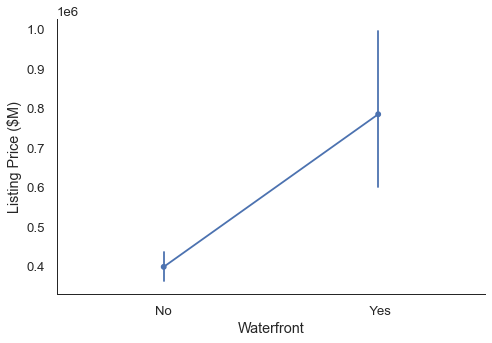

In [297]:
f = plt.figure(figsize=(20, 10))
sns.set_context('paper', font_scale = 1.5, rc = {"lines.linewidth": 1.0,'figure.figsize':(50,8.27)})
sns.set_style("white")

ax = sns.catplot(x="on_waterfront", y="price", kind="point", data=df,aspect=11.7/8.27)

ax.set(ylabel = "Listing Price ($M)", xlabel = "Waterfront")

plt.tight_layout()
plt.savefig('on_waterfront_catplot.png')

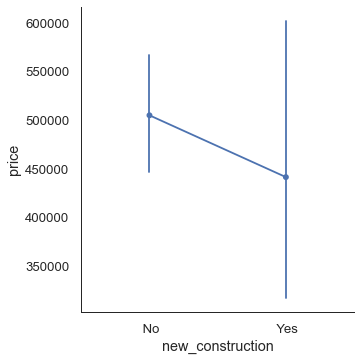

In [298]:
sns.catplot(x="new_construction", y="price", kind="point", data=df)

<Figure size 1440x720 with 0 Axes>

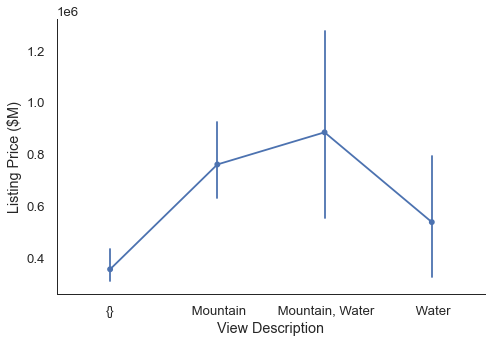

In [299]:
f = plt.figure(figsize=(20, 10))

sns.set_context('paper', font_scale = 1.5, rc = {"lines.linewidth": 1.0,'figure.figsize':(50,8.27)})
sns.set_style("white")

ax = sns.catplot(x="view_description", y="price", kind="point", data=df, aspect=11.7/8.27)
ax.set(ylabel = "Listing Price ($M)", xlabel = "View Description")

plt.tight_layout()
plt.savefig('view_description_catplot.png')

### Let's determing the impact of each categorical variable on other numerical variables

In [300]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sf', 'year_built', 'lot_size',
       'view_description', 'on_waterfront', 'house_style', 'new_construction',
       'garage_spaces', 'zip_code'],
      dtype='object')

### Start with waterfront

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

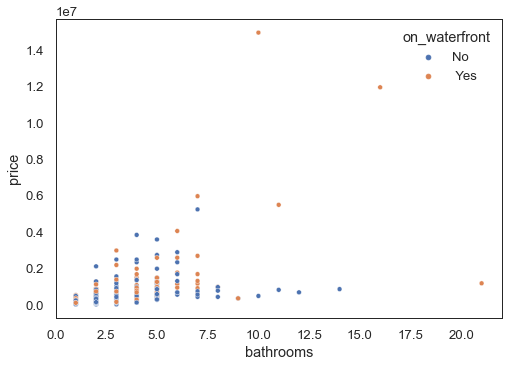

In [301]:
sns.scatterplot(x="bathrooms", y="price",hue="on_waterfront", data=df)

<AxesSubplot:xlabel='lot_size', ylabel='price'>

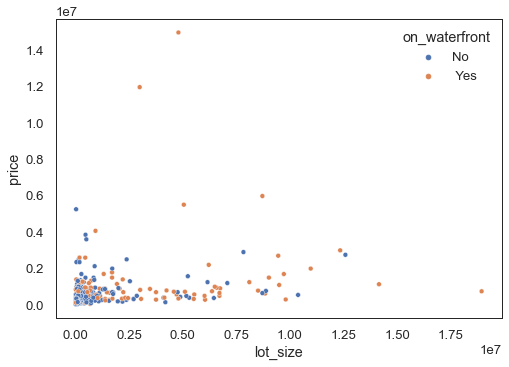

In [302]:
sns.scatterplot(x="lot_size", y="price",hue="on_waterfront",data=df)

<AxesSubplot:xlabel='garage_spaces', ylabel='price'>

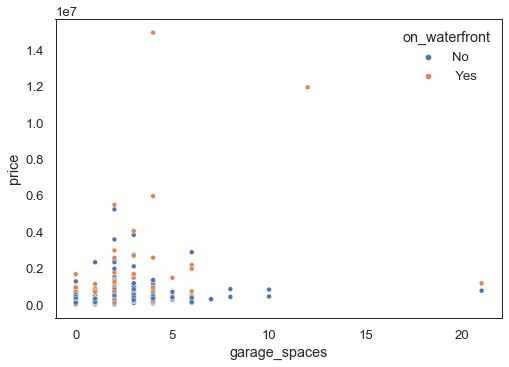

In [303]:
sns.scatterplot(x="garage_spaces", y="price",hue="on_waterfront",data=df)

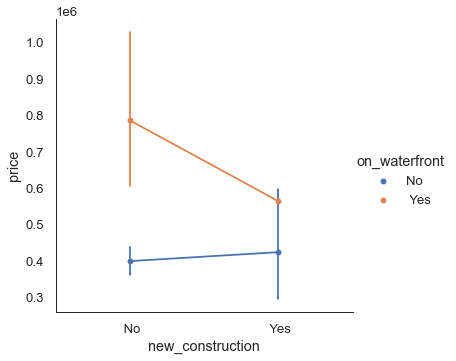

In [304]:
sns.catplot(x="new_construction", y="price", hue = "on_waterfront", kind="point", data=df)

In [305]:
mask = (df.on_waterfront == ' Yes')
mask2 = (df.on_waterfront == 'No')

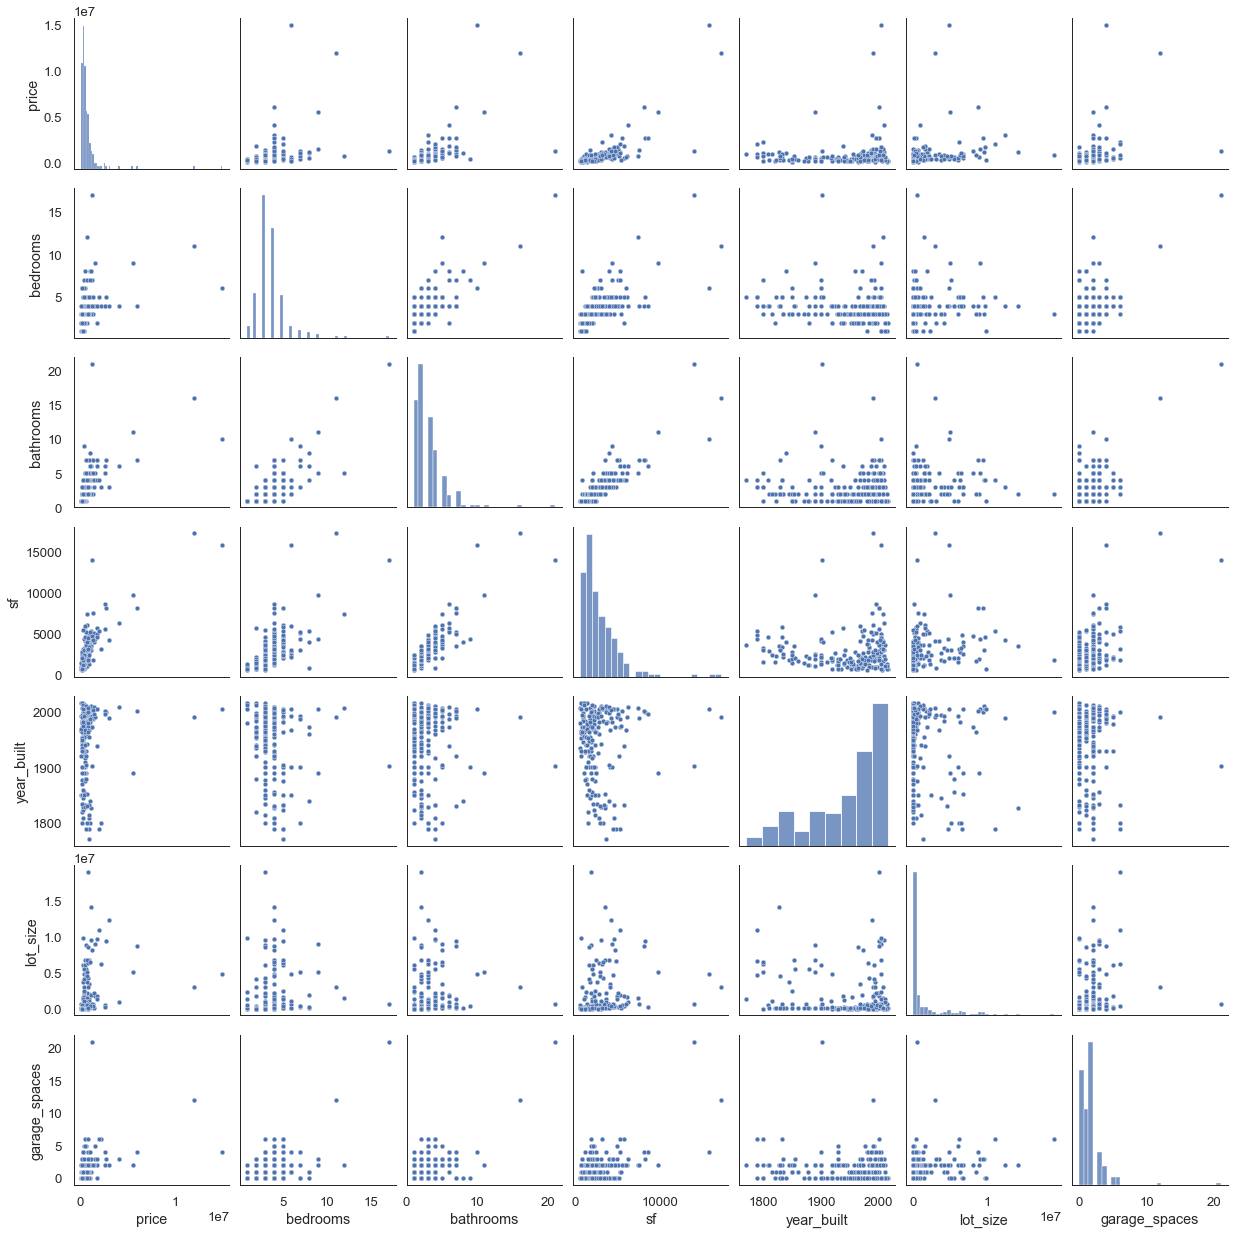

In [306]:
# Waterfront only

sns.pairplot(df[mask])

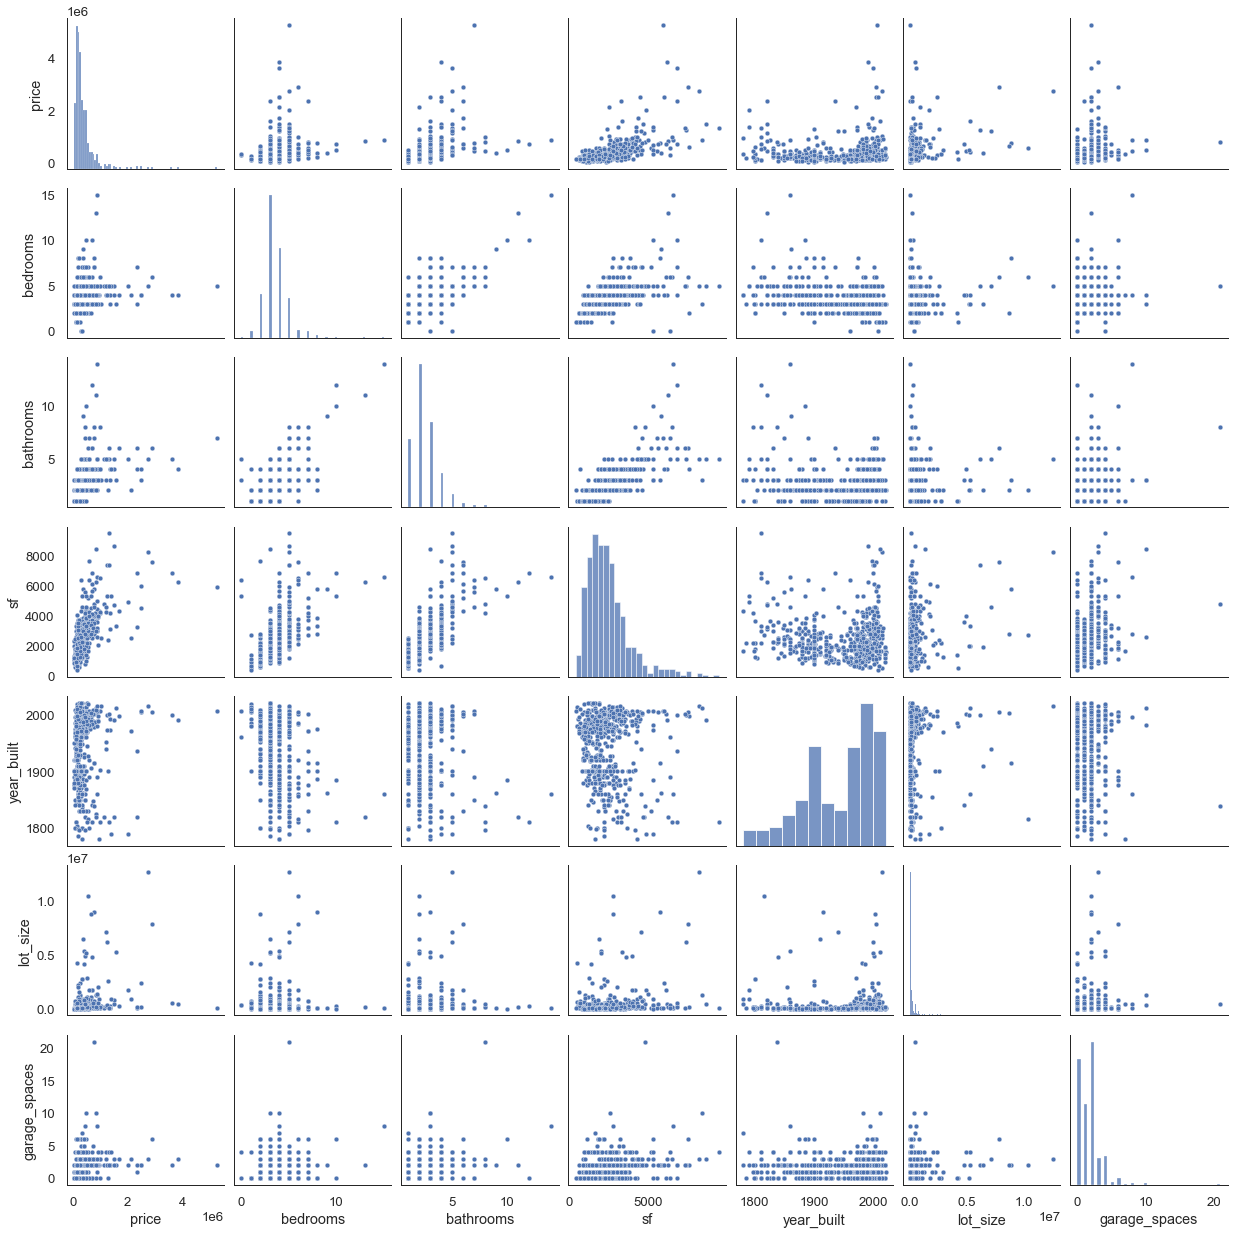

In [307]:
# Excluding waterfront

sns.pairplot(df[mask2])

In [308]:
# Waterfront only

df[mask].corr()

,price,bedrooms,bathrooms,sf,year_built,lot_size,garage_spaces
price,1.000000,0.349928,0.591804,0.779716,0.106550,0.269501,0.367065
bedrooms,0.349928,1.000000,0.765196,0.679500,-0.150840,0.117242,0.537412
bathrooms,0.591804,0.765196,1.000000,0.874950,0.039597,0.141927,0.638387
sf,0.779716,0.679500,0.874950,1.000000,0.035508,0.221386,0.592151
year_built,0.106550,-0.150840,0.039597,0.035508,1.000000,-0.078642,0.022939
lot_size,0.269501,0.117242,0.141927,0.221386,-0.078642,1.000000,0.188823
garage_spaces,0.367065,0.537412,0.638387,0.592151,0.022939,0.188823,1.000000


In [309]:
# Excluding waterfront

df[mask2].corr()

,price,bedrooms,bathrooms,sf,year_built,lot_size,garage_spaces
price,1.000000,0.268485,0.477390,0.636987,0.122499,0.310540,0.226553
bedrooms,0.268485,1.000000,0.671615,0.551005,-0.270522,0.083612,0.223173
bathrooms,0.477390,0.671615,1.000000,0.749870,-0.048901,0.100908,0.317978
sf,0.636987,0.551005,0.749870,1.000000,-0.046689,0.257984,0.320315
year_built,0.122499,-0.270522,-0.048901,-0.046689,1.000000,0.051601,0.018746
lot_size,0.310540,0.083612,0.100908,0.257984,0.051601,1.000000,0.107196
garage_spaces,0.226553,0.223173,0.317978,0.320315,0.018746,0.107196,1.000000


In [310]:
# All data 

df.corr()

,price,bedrooms,bathrooms,sf,year_built,lot_size,garage_spaces
price,1.000000,0.295404,0.531818,0.702748,0.101296,0.315941,0.276560
bedrooms,0.295404,1.000000,0.709588,0.605379,-0.226979,0.110349,0.338864
bathrooms,0.531818,0.709588,1.000000,0.814085,-0.011695,0.146997,0.447119
sf,0.702748,0.605379,0.814085,1.000000,-0.011003,0.252858,0.430629
year_built,0.101296,-0.226979,-0.011695,-0.011003,1.000000,-0.005619,0.020644
lot_size,0.315941,0.110349,0.146997,0.252858,-0.005619,1.000000,0.142634
garage_spaces,0.276560,0.338864,0.447119,0.430629,0.020644,0.142634,1.000000


# Simple Model - SF and Sale Price

Text(0.5, 1.0, 'House Price vs. Square Footage in VT')

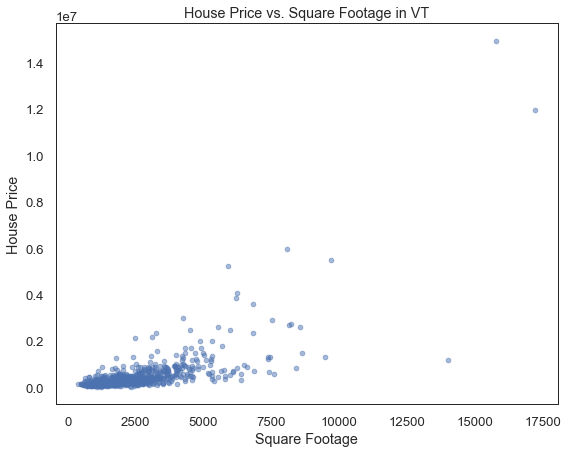

In [311]:
# Plot sale price vs. square footage

fig, ax = plt.subplots(figsize = (9,7))

x = df[['sf']]
y = df['price'] 

ax.scatter(x,y,alpha=.5)
ax.set_xlabel("Square Footage")
ax.set_ylabel("House Price")
ax.set_title("House Price vs. Square Footage in VT")

In [312]:
# Simple regression

lr = LinearRegression()

lr.fit(x,y)
lr.score(x,y)

0.4938553252449921

In [313]:
# Plot our prediction

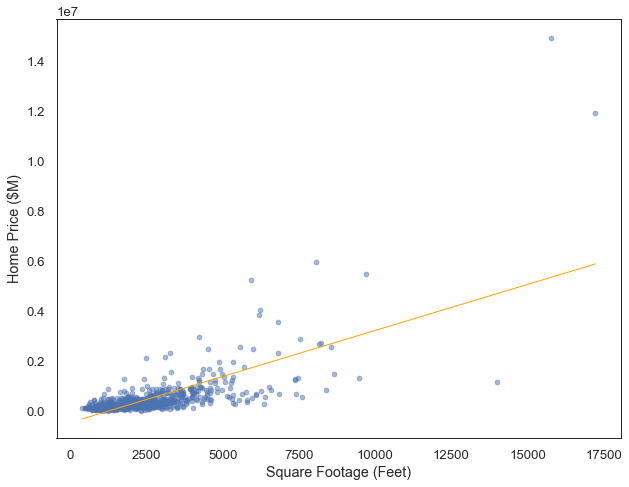

In [314]:
fig, ax = plt.subplots(figsize=(9, 7))
plt.xlabel("Square Footage (Feet)")
plt.ylabel("Home Price ($M)")


x = df[['sf']]
y = df['price']
ax.scatter(x, y, alpha=.5)

_x = np.linspace(x.min(), x.max())
_y = lr.predict(_x)

ax.plot(_x, _y, color='orange')
plt.tight_layout()
plt.savefig('sf&price.png')

In [315]:
# Caclulat eequation of line 

print(f'slope: {lr.coef_[0]:.2f}')
print(f'y-intercept: {lr.intercept_:.2f}')

slope: 368.43
y-intercept: -438274.59


# Categorical Variables 

In [316]:
# Start with on waterfront

df['on_waterfront'].value_counts()
cat_X = df.loc[:,["on_waterfront"]]
cat_Y = df['price']

In [317]:
ohe = OneHotEncoder(drop="first",sparse=False)

ohe.fit(cat_X)

ohe_X = ohe.transform(cat_X)

columns = ohe.get_feature_names(['on_waterfront'])

ohe_X_df = pd.DataFrame(ohe_X,columns = columns, index = cat_X.index)

In [318]:
cat_lr = LinearRegression()

cat_lr.fit(ohe_X_df, cat_Y)

cat_lr.score(ohe_X_df, cat_Y)

0.03699823724816731

In [319]:
cat_lr.coef_

array([-385673.70107858])

In [320]:
# Combining into one model

combined_df = pd.concat([ohe_X_df, df[['sf']]], axis=1)
combined_df.head()

,on_waterfront_No,sf
0,1.0,902.0
1,1.0,1680.0
3,1.0,1268.0
4,1.0,5788.0
5,1.0,1804.0


In [321]:
combined_lr = LinearRegression()

combined_lr.fit(combined_df, cat_Y)

combined_lr.score(combined_df, cat_Y)

0.5065476608000881

In [322]:
combined_lr.coef_, combined_lr.intercept_

(array([-227385.8438714 ,     361.62470497]), -255241.3519864304)

## Test and validate 

#### Start by excluding categorical variables

In [323]:
df.head()

,price,bedrooms,bathrooms,sf,year_built,lot_size,view_description,on_waterfront,house_style,new_construction,garage_spaces,zip_code
0,84900,2,2.0,902.0,1960.0,400752.0,{},No,Ranch,No,1,05045
1,335000,2,2.0,1680.0,1986.0,304920.0,{},No,Cape,No,0,05677
3,245000,3,2.0,1268.0,1960.0,174240.0,{},No,Cape,No,0,05730
4,374000,9,9.0,5788.0,1861.0,56628.0,{},No,Victorian,No,2,05143
5,360000,3,2.0,1804.0,1962.0,18295.0,{},No,Raised Ranch,No,2,05482


In [324]:
df.dtypes

price                 int64
bedrooms              int64
bathrooms           float64
sf                  float64
year_built          float64
lot_size            float64
view_description     object
on_waterfront        object
house_style          object
new_construction     object
garage_spaces         int64
zip_code             object
dtype: object

In [325]:
df = df.drop(index= 49)

In [326]:
#Separate our features from our target

X = df.loc[:,['bedrooms','bathrooms','sf','year_built','lot_size','garage_spaces']]

y = df['price']

In [327]:
X.shape

(728, 6)

In [328]:
y.shape

(728,)

In [329]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on training & validation data
    train_score = lr_model.score(X_train, y_train)
    val_score = lr_model.score(X_val, y_val)
    
    # report training results
    print('\nTraining R^2 score was:', train_score)
    
    # report validation results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

In [330]:
split_and_validate(X, y)


Training R^2 score was: 0.5658246093114221

Validation R^2 score was: 0.09202686977449115
Feature coefficient results: 

bedrooms : -123583.57
bathrooms : 19569.24
sf : 425.47
year_built : 1364.16
lot_size : 0.07
garage_spaces : -22576.24


## Try squaring certain terms

In [331]:
#Separate our features from our target

X1 = df.loc[:,['bedrooms','bathrooms','sf']]
y = df['price']

X1['bed2'] = X1['bedrooms'] ** 2
X1['bath2'] = X1['bathrooms'] ** 2

In [332]:
split_and_validate(X1, y)


Training R^2 score was: 0.5844075135684519

Validation R^2 score was: 0.10992324765490247
Feature coefficient results: 

bedrooms : 213913.54
bathrooms : -178824.16
sf : 426.66
bed2 : -38021.33
bath2 : 24665.06


In [333]:
X1['sf3'] = X1['sf'] ** 3

split_and_validate(X1, y)


Training R^2 score was: 0.7799902826531919

Validation R^2 score was: 0.36099141995747175
Feature coefficient results: 

bedrooms : 29573.18
bathrooms : 270987.26
sf : 65.34
bed2 : -8078.51
bath2 : -22323.78
sf3 : 0.00


In [334]:
# Testing for presentation of basic model

X_pres = X1.copy()
X_pres['sf3'] = X_pres['sf'] ** 2
X_pres = X_pres.drop(['bedrooms'], axis=1)
X_pres = X_pres.drop(['bathrooms'], axis=1)
X_pres = X_pres.drop(['bed2'], axis=1)
X_pres = X_pres.drop(['bath2'], axis=1)
X_pres = X_pres.drop(['sf'], axis=1)

split_and_validate(X_pres, y)


Training R^2 score was: 0.6779393955337585

Validation R^2 score was: 0.3394751335637154
Feature coefficient results: 

sf3 : 0.04


In [335]:
# Testing for presentation of basic model

X_pres2 = X1.copy()

X_pres2 = X_pres2.drop(['bedrooms'], axis=1)
X_pres2 = X_pres2.drop(['bathrooms'], axis=1)
X_pres2 = X_pres2.drop(['sf3'], axis=1)
X_pres2 = X_pres2.drop(['bed2'], axis=1)
X_pres2 = X_pres2.drop(['bath2'], axis=1)

split_and_validate(X_pres2, y)


Training R^2 score was: 0.5066136057242914

Validation R^2 score was: 0.24295516705196896
Feature coefficient results: 

sf : 383.53


# Adding Categorical Variables

### Waterfront

In [336]:
df['on_waterfront'].value_counts()

No      530
 Yes    198
Name: on_waterfront, dtype: int64

In [337]:
pd.get_dummies(df['on_waterfront']).head()

,Yes,No
0,0,1
1,0,1
3,0,1
4,0,1
5,0,1


In [338]:
X2 = X.copy()

X2['on_waterfront'] = df['on_waterfront']

split_and_validate(pd.get_dummies(X2), y)


Training R^2 score was: 0.5713722170492914

Validation R^2 score was: 0.10201667106426937
Feature coefficient results: 

bedrooms : -122245.13
bathrooms : 14048.68
sf : 426.09
year_built : 1329.77
lot_size : 0.06
garage_spaces : -20429.22
on_waterfront_ Yes : 84793.97
on_waterfront_No : -84793.97


In [339]:
# Confused why bedrooms is negative

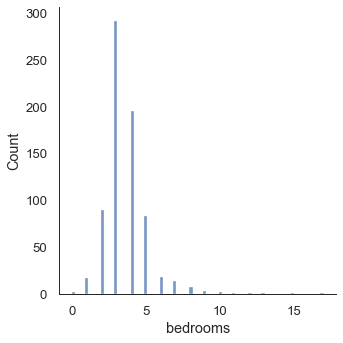

In [340]:
sns.displot(df, x="bedrooms")

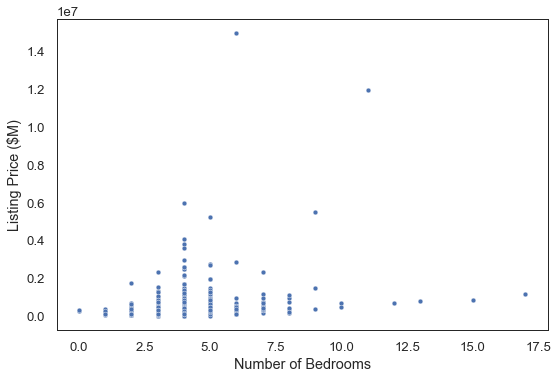

In [341]:
ax = sns.scatterplot(x="bedrooms", y="price",data=df)
ax.set(ylabel = "Listing Price ($M)", xlabel = "Number of Bedrooms")

plt.tight_layout()
plt.savefig('bedrooms&price.png')

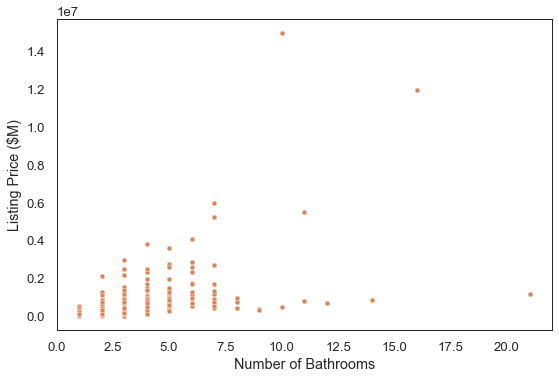

In [342]:
ax = sns.scatterplot(x="bathrooms", y="price",data=df)

sns.scatterplot(x="bathrooms", y="price",data=df)
ax.set(ylabel = "Listing Price ($M)", xlabel = "Number of Bathrooms")

plt.tight_layout()
plt.savefig('bathrooms&price.png')

<AxesSubplot:xlabel='lot_size', ylabel='price'>

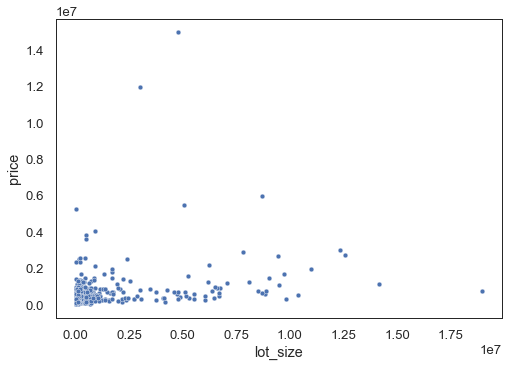

In [343]:
sns.scatterplot(x="lot_size", y="price",data=df)

## Interaction Terms

<AxesSubplot:xlabel='year_built', ylabel='price'>

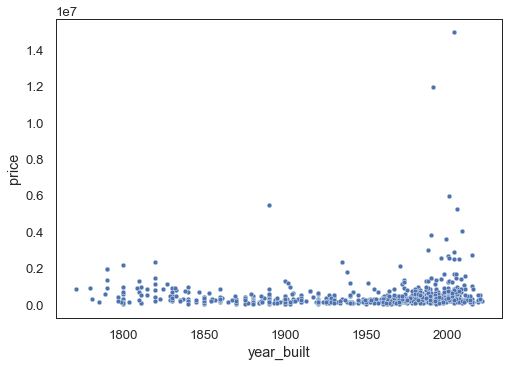

In [344]:
sns.scatterplot(x="year_built", y="price",data=df)

In [345]:
# Looking back at the homes, it appears to be these 
#old, large homes are less expensive and have many bathrooms/beds

In [346]:
# Adding interaction terms of year_built on bedrooms and bathrooms

In [347]:
X3 = X2.copy()

# multiplicative interaction
X3['Bed_x_YB'] = X3['bedrooms'] * X3['year_built']

# division interaction
X3['Bath_x_YB'] = X3['bathrooms'] * X3['year_built']

split_and_validate(pd.get_dummies(X3), y)


Training R^2 score was: 0.6035531148352972

Validation R^2 score was: 0.027396287670986674
Feature coefficient results: 

bedrooms : 900533.12
bathrooms : -3560574.41
sf : 344.62
year_built : -2312.26
lot_size : 0.06
garage_spaces : -25558.84
Bed_x_YB : -516.19
Bath_x_YB : 1885.41
on_waterfront_ Yes : 78418.61
on_waterfront_No : -78418.61


In [348]:
X4 = X2.copy()

# division interaction
X4['Bath_x_YB'] = X4['bathrooms'] * X4['year_built']
X4 = X4.drop(['garage_spaces'], axis=1)

split_and_validate(pd.get_dummies(X4), y)


Training R^2 score was: 0.6008853244010044

Validation R^2 score was: 0.09751513772039166
Feature coefficient results: 

bedrooms : -104274.62
bathrooms : -2901415.54
sf : 338.19
year_built : -3406.65
lot_size : 0.06
Bath_x_YB : 1544.58
on_waterfront_ Yes : 78260.52
on_waterfront_No : -78260.52


## Adding more categorical variables and interaction terms

In [349]:
df["view_description"].replace({"{}":"None"}, inplace=True)

In [350]:
pd.get_dummies(df['view_description']).head()

,Mountain,"Mountain, Water",Water,None
0,0,0,0,1
1,0,0,0,1
3,0,0,0,1
4,0,0,0,1
5,0,0,0,1


In [351]:
# View description gets worse

X5 = X2.copy()

# division interaction
X5['Bath_x_YB'] = X5['bathrooms'] * X5['year_built']
X5 = X5.drop(['garage_spaces'], axis=1)
X5['view_description'] = df['view_description']

split_and_validate(pd.get_dummies(X5), y)


Training R^2 score was: 0.6048560304960573

Validation R^2 score was: 0.05151301495706495
Feature coefficient results: 

bedrooms : -104360.90
bathrooms : -2941557.08
sf : 342.32
year_built : -3328.96
lot_size : 0.07
Bath_x_YB : 1567.09
on_waterfront_ Yes : 68308.95
on_waterfront_No : -68308.95
view_description_ Mountain : -114633.29
view_description_ Mountain, Water : 77140.01
view_description_ Water : 12447.66
view_description_None : 25045.62


In [352]:
# Adding interaction term for new construction

X6 = X2.copy()

# division interaction
X6['Bath_x_YB'] = X6['bathrooms'] * X6['year_built']
X6 = X6.drop(['garage_spaces'], axis=1)
X6['new_construction'] = df['new_construction']


split_and_validate(pd.get_dummies(X6), y)


Training R^2 score was: 0.6009435364357621

Validation R^2 score was: 0.09642125392116385
Feature coefficient results: 

bedrooms : -104418.40
bathrooms : -2894154.02
sf : 339.03
year_built : -3408.76
lot_size : 0.06
Bath_x_YB : 1540.43
on_waterfront_ Yes : 78789.38
on_waterfront_No : -78789.38
new_construction_ No : -40652.23
new_construction_ Yes : 40652.23


### Zip Code

In [353]:
zip_code_counts = df.zip_code.value_counts()
df_zip_code = pd.DataFrame(zip_code_counts)

In [354]:
#sns.displot(df_zip_code, x="zip_code")

In [355]:
zip_code_counts

05701    36
05143    21
05301    18
05201    16
05251    15
         ..
05061     1
05778     1
05058     1
05067     1
05257     1
Name: zip_code, Length: 196, dtype: int64

In [356]:
other_zips = list(zip_code_counts[zip_code_counts <= 7].index)

X7 = X6.copy()

X7['zip_code'] = df['zip_code'].replace(other_zips, 'Other')
X7['view_description'] = df['view_description']
X7 = X7.drop(['bedrooms'], axis=1)

split_and_validate(pd.get_dummies(X7), y)


Training R^2 score was: 0.6863227007273867

Validation R^2 score was: 0.1151254508888856
Feature coefficient results: 

bathrooms : -2117720.36
sf : 286.07
year_built : -1856.72
lot_size : 0.08
Bath_x_YB : 1102.05
on_waterfront_ Yes : 64312.17
on_waterfront_No : -64312.17
new_construction_ No : -72420.77
new_construction_ Yes : 72420.77
zip_code_05143 : -246426.82
zip_code_05149 : -32604.98
zip_code_05156 : -111199.69
zip_code_05201 : -252592.25
zip_code_05251 : 175618.00
zip_code_05301 : -147465.80
zip_code_05356 : -257910.19
zip_code_05363 : -66487.21
zip_code_05641 : -140758.54
zip_code_05661 : 261126.00
zip_code_05672 : 2548757.23
zip_code_05701 : -81524.07
zip_code_05733 : -199500.84
zip_code_05743 : -386343.88
zip_code_05753 : -8162.44
zip_code_05764 : -338268.05
zip_code_05819 : -191520.61
zip_code_05830 : -107679.32
zip_code_05855 : -252410.35
zip_code_Other : -164646.19
view_description_ Mountain : -160500.52
view_description_ Mountain, Water : 150074.42
view_description_ Wat

In [357]:
# Try stripping down the variables amd addomg polynomials

X8 = X7.copy()

X8 = X8.drop(['year_built'], axis=1)
X8['sf3'] = X8['sf'] ** 3
X8['bathrooms3'] = X8['bathrooms'] ** 3
X8 = X8.drop(['new_construction'], axis=1)
X8 = X8.drop(['sf'], axis=1)
X8['on_waterfront'] = pd.get_dummies(X8['on_waterfront'])
X8['on_waterfrontXSF'] = X8['on_waterfront'] * df['sf'] ** 2
X8['on_waterfrontXbedrooms'] = X8['on_waterfront'] * df['bedrooms'] ** 3

#split_and_validate(pd.get_dummies(X8), y)

In [358]:
# Adding view description

X9 = X8.copy()

X9['view_description'] = pd.get_dummies(X9['view_description'])
X9['view_descriptionXbathrooms'] = X9['view_description'] * X9['on_waterfront'] 
X9['sfXlot_size2'] = X9['lot_size'] * df['sf'] **2
X9['on_waterfrontXview_description'] = X9['view_description'] * X9['on_waterfront'] 
X9 = X9.drop(['bathrooms'], axis=1)
X9 = X9.drop(['lot_size'], axis=1)

split_and_validate(pd.get_dummies(X9), y)


Training R^2 score was: 0.8717755376710488

Validation R^2 score was: 0.5777634433462497
Feature coefficient results: 

on_waterfront : 112017.73
Bath_x_YB : 65.41
view_description : 119116.66
sf3 : 0.00
bathrooms3 : -590.40
on_waterfrontXSF : 0.02
on_waterfrontXbedrooms : -615.30
view_descriptionXbathrooms : -150551.11
sfXlot_size2 : 0.00
on_waterfrontXview_description : -151560.60
zip_code_05143 : -108465.44
zip_code_05149 : 75644.62
zip_code_05156 : -139899.78
zip_code_05201 : -150760.80
zip_code_05251 : 443586.61
zip_code_05301 : -127168.78
zip_code_05356 : -155106.55
zip_code_05363 : -163172.14
zip_code_05641 : -111928.83
zip_code_05661 : 469414.54
zip_code_05672 : 1122712.72
zip_code_05701 : -37713.58
zip_code_05733 : -188319.56
zip_code_05743 : -223213.94
zip_code_05753 : -3457.46
zip_code_05764 : -134406.54
zip_code_05819 : -95606.39
zip_code_05830 : -165250.54
zip_code_05855 : -241004.21
zip_code_Other : -65806.86


## Adding a train/val/test to above model

In [359]:
#Split the data 60 - 20 - 20 train/val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(pd.get_dummies(X9), y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [360]:
# fit linear regression to training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
    
# score fit model on training & validation data
train_score = lr_model.score(X_train, y_train)
val_score = lr_model.score(X_val, y_val)
test_score = lr_model.score(X_test,y_test)
    
# report training results
print('\nTraining R^2 score was:', train_score)
    
# report validation results
print('\nValidation R^2 score was:', val_score)

#report test results
print('\ntest R^2 score was:', test_score)
y_true = y_test
y_predict = lr_model.predict(X_test)
print('\ntest RMSE score was:', math.sqrt(mean_squared_error(y_true,y_predict)))
print('\ntest MAE score was:', mean_absolute_error(y_true,y_predict))

print('Feature coefficient results: \n')
for feature, coef in zip(pd.get_dummies(X9).columns, lr_model.coef_):
    print(feature, ':', f'{coef:.2f}') 


Training R^2 score was: 0.9099897728001356

Validation R^2 score was: 0.45376971265990484

test R^2 score was: 0.5461424128010763

test RMSE score was: 313307.67462307896

test MAE score was: 178156.42952692747
Feature coefficient results: 

on_waterfront : 63764.66
Bath_x_YB : 59.71
view_description : 87739.04
sf3 : 0.00
bathrooms3 : -424.28
on_waterfrontXSF : 0.02
on_waterfrontXbedrooms : -819.84
view_descriptionXbathrooms : -108408.86
sfXlot_size2 : 0.00
on_waterfrontXview_description : -114298.18
zip_code_05143 : -93438.22
zip_code_05149 : 18912.12
zip_code_05156 : -139190.26
zip_code_05201 : -174273.27
zip_code_05251 : 589925.47
zip_code_05301 : -87464.39
zip_code_05356 : -170122.46
zip_code_05363 : -118108.20
zip_code_05641 : -114215.73
zip_code_05661 : 454652.78
zip_code_05672 : 793244.02
zip_code_05701 : -31452.64
zip_code_05733 : -158178.68
zip_code_05743 : -178444.97
zip_code_05753 : 21898.83
zip_code_05764 : -119794.71
zip_code_05819 : -107201.10
zip_code_05830 : -155600.15

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

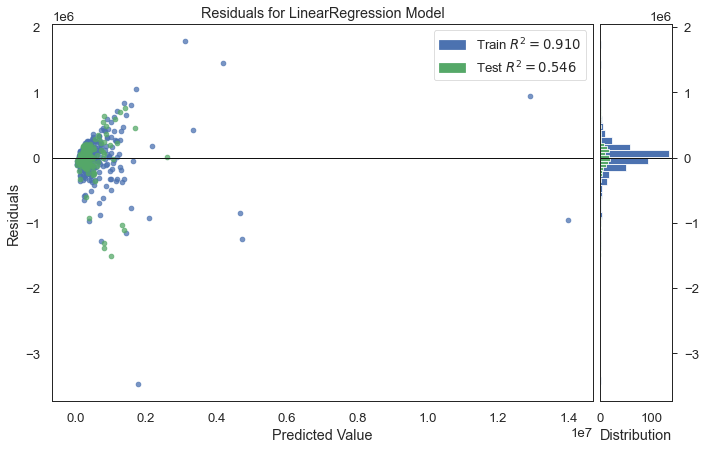

In [361]:
from yellowbrick.features import RadViz
visualizer = visualizer = RadViz(size = (800,500))

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from yellowbrick.features import RadViz
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = lr_model
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)
visualizer.show(outpath="best_model_res1.png")      
# Finalize and render the figure

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

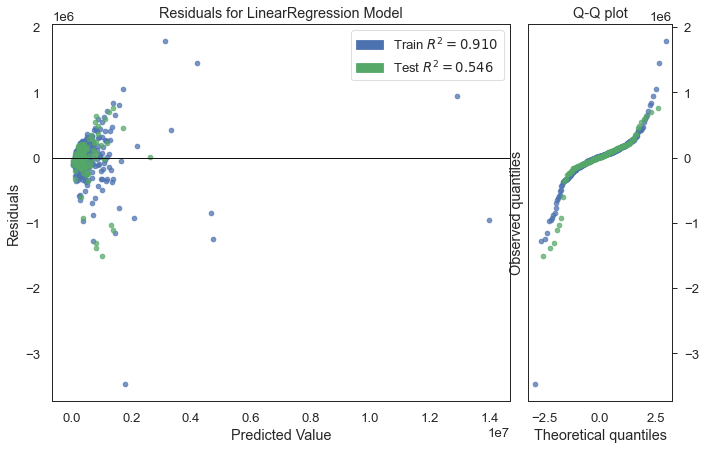

In [362]:
visualizer = visualizer = RadViz(size = (800,500))

visualizer = ResidualsPlot(model, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show(outpath="best_model_res2.png")    

In [363]:
residual = (y_true - y_predict)

In [364]:
residual_table = pd.DataFrame(residual)
residual_table = residual_table.rename(columns={"price":"res"})

In [365]:
residual_table.shape

(146, 1)

In [366]:
result = pd.merge(residual_table, df, left_index=True, right_index=True)

In [367]:
result.shape

(146, 13)

In [368]:
result.sort_values(by=['res'],ascending=False).head(10)

,res,price,bedrooms,bathrooms,sf,year_built,lot_size,view_description,on_waterfront,house_style,new_construction,garage_spaces,zip_code
625,1.500889e+06,2500000,4,4.0,5985.0,2007.0,2374020.0,Mountain,No,"Colonial,Farmhouse,Federal",No,2,05055
567,1.390016e+06,2199000,4,3.0,3100.0,1800.0,6207736.0,Water,Yes,"Cape,Farmhouse",No,6,05091
486,1.313012e+06,2125000,4,2.0,2490.0,1971.0,879912.0,None,No,Contemporary,No,3,05661
386,1.115519e+06,2500000,4,3.0,4506.0,2004.0,138521.0,Mountain,No,Farmhouse,No,2,05672
503,1.033315e+06,2350000,3,4.0,3257.0,1820.0,28750.0,None,No,"Antique,Cape",No,1,05672
425,9.214445e+05,1295000,3,2.0,1763.0,1987.0,294030.0,"Mountain, Water",Yes,"Cottage/Camp,Ranch",No,2,05491
654,5.968623e+05,895000,3,2.0,2350.0,1815.0,1110780.0,Mountain,Yes,"Antique,Cape,Historic Vintage",No,1,05031
208,3.564321e+05,905000,4,3.0,2664.0,1973.0,31363.0,None,Yes,Raised Ranch,No,2,05486
322,3.301175e+05,449000,8,4.0,768.0,1960.0,261360.0,"Mountain, Water",Yes,Cabin,No,1,05846
791,2.602302e+05,749900,4,3.0,3114.0,2007.0,117176.0,Mountain,Yes,Contemporary,No,2,05440


In [369]:
result.sort_values(by=['res'],ascending=True).head(20)

,res,price,bedrooms,bathrooms,sf,year_built,lot_size,view_description,on_waterfront,house_style,new_construction,garage_spaces,zip_code
557,-765402.006963,629000,4,7.0,5148.0,1920.0,174240.0,None,Yes,Other,No,0,05340
169,-704690.761727,549000,5,3.0,3082.0,2001.0,42689.0,None,No,"Contemporary,Craftsman",No,0,05672
254,-633123.574607,169000,2,1.0,1200.0,1930.0,40946.0,None,No,Multi Level,No,0,05251
149,-598751.744082,525000,5,3.0,2625.0,1945.0,121968.0,Mountain,No,Cape,No,3,05251
101,-547918.711583,229900,5,2.0,2184.0,1880.0,13068.0,None,No,Farmhouse,No,0,05661
401,-479370.393778,399000,2,2.0,1632.0,1979.0,439956.0,Mountain,No,Contemporary,No,1,05661
772,-450157.374693,1250000,4,5.0,4728.0,1973.0,8102160.0,Mountain,Yes,Farmhouse,No,2,05738
162,-364605.307724,499000,3,2.0,1320.0,1940.0,161172.0,"Mountain, Water",Yes,Cottage/Camp,No,0,05661
132,-342842.389014,291000,4,5.0,2168.0,1894.0,493535.0,Mountain,No,Farmhouse,No,1,05847
586,-280475.921582,279500,3,3.0,2396.0,1990.0,599821.0,"Mountain, Water",Yes,Ranch,No,4,05829


### Adding median family income

In [370]:
X9.head()

,on_waterfront,Bath_x_YB,zip_code,view_description,sf3,bathrooms3,on_waterfrontXSF,on_waterfrontXbedrooms,view_descriptionXbathrooms,sfXlot_size2,on_waterfrontXview_description
0,0,3920.0,Other,0,7.338708e+08,8.0,0.0,0,0,3.260534e+11,0
1,0,3972.0,Other,0,4.741632e+09,8.0,0.0,0,0,8.606062e+11,0
3,0,3920.0,Other,0,2.038721e+09,8.0,0.0,0,0,2.801473e+11,0
4,0,16749.0,05143,0,1.939035e+11,729.0,0.0,0,0,1.897091e+12,0
5,0,3924.0,Other,0,5.870966e+09,8.0,0.0,0,0,5.953954e+10,0


In [371]:
df_agg_income.shape

(309, 3)

In [372]:
# Add a zip_code that is not binary
X10 = X9.copy()
X10['non_dummy_zip'] = df['zip_code']
X10.shape

(728, 12)

In [373]:
X10['non_dummy_zip'] = pd.to_numeric(X10['non_dummy_zip'])

In [374]:
X11 = pd.merge(left = X10, right = df_agg_income,how = 'left', left_on = 'non_dummy_zip', right_on='zip_code')

In [375]:
X11.shape

(728, 15)

In [376]:
X11.tail(100)

,on_waterfront,Bath_x_YB,zip_code_x,view_description,sf3,bathrooms3,on_waterfrontXSF,on_waterfrontXbedrooms,view_descriptionXbathrooms,sfXlot_size2,on_waterfrontXview_description,non_dummy_zip,zip_code_y,county,median_income
628,1,8020.0,Other,1,9.320615e+10,64.0,20557156.0,64,1,1.996897e+14,1,5355,5355.0,Windham,70900.0
629,0,5655.0,Other,0,4.353991e+10,27.0,0.0,0,0,4.097306e+11,0,5845,5845.0,Orleans,59800.0
630,1,1964.0,Other,0,6.076454e+08,1.0,717409.0,8,0,5.312414e+09,0,5446,5446.0,Chittenden,89700.0
631,0,4006.0,Other,1,9.651309e+10,8.0,0.0,0,0,2.978713e+12,0,5777,5777.0,Rutland,71500.0
632,1,5892.0,Other,0,1.327838e+10,27.0,5607424.0,125,0,4.127961e+11,0,5463,5463.0,Grand Isle,89700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1,11922.0,05301,0,1.447031e+11,216.0,27562500.0,343,0,1.200622e+13,0,5301,5301.0,Windham,70900.0
724,1,6021.0,Other,1,3.019645e+10,27.0,9696996.0,64,1,1.136255e+12,1,5440,5440.0,Grand Isle,89700.0
725,1,1930.0,Other,0,3.579110e+08,1.0,504100.0,27,0,4.830790e+09,0,5769,5769.0,Addison,80700.0
726,0,3720.0,05149,0,1.113438e+10,8.0,0.0,0,0,1.238046e+11,0,5149,5149.0,Windsor,79300.0


In [377]:
#Drop zip code
X11 = X11.drop(['non_dummy_zip'], axis = 1)

In [378]:
X11.shape

(728, 14)

In [379]:
y.shape

(728,)

In [380]:
null_data = X11[X11.isnull().any(axis=1)]
null_data

,on_waterfront,Bath_x_YB,zip_code_x,view_description,sf3,bathrooms3,on_waterfrontXSF,on_waterfrontXbedrooms,view_descriptionXbathrooms,sfXlot_size2,on_waterfrontXview_description,zip_code_y,county,median_income
48,0,3984.0,Other,1,2.767587e+09,8.0,0.0,0,0,9.874609e+11,0,NaN,NaN,NaN


In [381]:
X11 = X11.drop(index= 48)
y = y.drop(index = 48)

In [382]:
X11 = X11.drop(['zip_code_y'], axis = 1)
X11 = X11.drop(['county'], axis = 1)

In [383]:
# perform train/val split
X_train, X_val, y_train, y_val = \
    train_test_split(pd.get_dummies(X11), y, test_size=0.2, random_state=42)
    
# fit linear regression to training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
    
# score fit model on training & validation data
train_score = lr_model.score(X_train, y_train)
val_score = lr_model.score(X_val, y_val)
    
# report training results
print('\nTraining R^2 score was:', train_score)
    
# report validation results
print('\nValidation R^2 score was:', val_score)
print('Feature coefficient results: \n')
for feature, coef in zip(pd.get_dummies(X11).columns, lr_model.coef_):
    print(feature, ':', f'{coef:.2f}') 


Training R^2 score was: 0.8753042432246368

Validation R^2 score was: 0.24736658119975352
Feature coefficient results: 

on_waterfront : 146805.35
Bath_x_YB : 69.30
view_description : 147541.82
sf3 : 0.00
bathrooms3 : -584.23
on_waterfrontXSF : 0.02
on_waterfrontXbedrooms : -621.57
view_descriptionXbathrooms : -147079.84
sfXlot_size2 : 0.00
on_waterfrontXview_description : -159099.92
median_income : 6.09
zip_code_x_05143 : -167315.85
zip_code_x_05149 : -5234.94
zip_code_x_05156 : -162054.31
zip_code_x_05201 : -106808.93
zip_code_x_05251 : 375594.60
zip_code_x_05301 : -83630.41
zip_code_x_05356 : -165141.41
zip_code_x_05363 : -208519.88
zip_code_x_05641 : -142508.21
zip_code_x_05661 : 264888.66
zip_code_x_05672 : 1528592.59
zip_code_x_05701 : -30360.80
zip_code_x_05733 : -213531.75
zip_code_x_05743 : -251897.73
zip_code_x_05753 : -54548.70
zip_code_x_05764 : -166421.97
zip_code_x_05819 : -56101.02
zip_code_x_05830 : -90373.35
zip_code_x_05855 : -163284.25
zip_code_x_Other : -101384.31


### Are there any ways that I can make the above more accurate through dropping terms or interaction terms?

#### Try dropping zip codes

In [384]:
X11.head()

,on_waterfront,Bath_x_YB,zip_code_x,view_description,sf3,bathrooms3,on_waterfrontXSF,on_waterfrontXbedrooms,view_descriptionXbathrooms,sfXlot_size2,on_waterfrontXview_description,median_income
0,0,3920.0,Other,0,7.338708e+08,8.0,0.0,0,0,3.260534e+11,0,74400.0
1,0,3972.0,Other,0,4.741632e+09,8.0,0.0,0,0,8.606062e+11,0,80300.0
2,0,3920.0,Other,0,2.038721e+09,8.0,0.0,0,0,2.801473e+11,0,71500.0
3,0,16749.0,05143,0,1.939035e+11,729.0,0.0,0,0,1.897091e+12,0,79300.0
4,0,3924.0,Other,0,5.870966e+09,8.0,0.0,0,0,5.953954e+10,0,89700.0


In [385]:
X12 = X11.copy()

In [386]:
X12 = X12.drop(['zip_code_x'], axis = 1)

In [387]:
# perform train/val split
X_train, X_val, y_train, y_val = \
    train_test_split(pd.get_dummies(X12), y, test_size=0.2, random_state=42)
    
# fit linear regression to training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
    
# score fit model on training & validation data
train_score = lr_model.score(X_train, y_train)
val_score = lr_model.score(X_val, y_val)
    
# report training results
print('\nTraining R^2 score was:', train_score)
    
# report validation results
print('\nValidation R^2 score was:', val_score)
print('Feature coefficient results: \n')
for feature, coef in zip(pd.get_dummies(X11).columns, lr_model.coef_):
    print(feature, ':', f'{coef:.2f}') 


Training R^2 score was: 0.8397644189842706

Validation R^2 score was: 0.33304519089765483
Feature coefficient results: 

on_waterfront : 138141.11
Bath_x_YB : 73.03
view_description : 187695.89
sf3 : 0.00
bathrooms3 : -622.28
on_waterfrontXSF : 0.02
on_waterfrontXbedrooms : -787.19
view_descriptionXbathrooms : -163653.56
sfXlot_size2 : 0.00
on_waterfrontXview_description : -163653.56
median_income : 4.98


### Generating Interaction Terms and using Lasso

#### Without lasso

In [388]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sf', 'year_built', 'lot_size',
       'view_description', 'on_waterfront', 'house_style', 'new_construction',
       'garage_spaces', 'zip_code'],
      dtype='object')

In [389]:
# Set x and y

x_train, x_test, y_train, y_test = train_test_split(
    df[['bedrooms','bathrooms','sf','sf','lot_size', 'view_description',
       'on_waterfront','house_style','new_construction','garage_spaces',
       'zip_code']], df['price']
    , test_size=0.33, random_state=42)

In [390]:
m = LinearRegression()

In [391]:
# Train

from sklearn.preprocessing import PolynomialFeatures
p = PolynomialFeatures(degree=2,interaction_only=True)
# Get dummies
x_train['on_waterfront'] = pd.get_dummies(x_train['on_waterfront'],drop_first=True)
x_train['view_description'] = pd.get_dummies(x_train['view_description'],drop_first=True)
x_train['house_style'] = pd.get_dummies(x_train['house_style'],drop_first=True)
x_train['new_construction'] = pd.get_dummies(x_train['new_construction'],drop_first=True)
x_train_poly = p.fit_transform(x_train)
# Fit and score
m.fit(x_train_poly,y_train)
m.score(x_train_poly,y_train)

0.8276482360366672

In [392]:
#list(zip(p.get_feature_names(['bedrooms','bathrooms','sf','sf','lot_size', 'view_description',
#       'on_waterfront','house_style','new_construction','garage_spaces',
#       'zip_code']),m.coef_))

In [393]:
# Apply to test data
x_test['on_waterfront'] = pd.get_dummies(x_test['on_waterfront'],drop_first=True)
x_test['view_description'] = pd.get_dummies(x_test['view_description'],drop_first=True)
x_test['house_style'] = pd.get_dummies(x_test['house_style'],drop_first=True)
x_test['new_construction'] = pd.get_dummies(x_test['new_construction'],drop_first=True)
#Transform and score
x_test_poly = p.transform(x_test)
m.score(x_test_poly,y_test)

-17.767927745763025

### Apply Lasso - all variables / interaction terms (includes squaring)

In [394]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

In [395]:
# Set x and y

x_train, x_test, y_train, y_test = train_test_split(
    df[['bedrooms','bathrooms','sf','sf','lot_size', 'view_description',
       'on_waterfront','house_style','new_construction','garage_spaces',
       'zip_code']], df['price']
    , test_size=0.33, random_state=42)

In [396]:
# Lasso squared and interaction terms training

m = LassoCV()
p = PolynomialFeatures(degree=2)
# Create Dummies
x_train['on_waterfront'] = pd.get_dummies(x_train['on_waterfront'],drop_first=True)
x_train['view_description'] = pd.get_dummies(x_train['view_description'],drop_first=True)
x_train['house_style'] = pd.get_dummies(x_train['house_style'],drop_first=True)
x_train['new_construction'] = pd.get_dummies(x_train['new_construction'],drop_first=True)
x_train_poly = p.fit_transform(x_train)
# Standardize, train, and fit 
s = StandardScaler(with_mean=False)
x_train_poly_scaled = s.fit_transform(x_train_poly)
m.fit(x_train_poly_scaled,y_train)
m.score(x_train_poly_scaled,y_train)

C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18436065878.140625, tolerance: 15299476078.500631
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17246513067.4375, tolerance: 15299476078.500631
  model = cd_fast.enet_coordinate_descent_gram(


0.8303259110554218

In [397]:
# Lasso squared and interaction terms test

# Create Dummies
x_test['on_waterfront'] = pd.get_dummies(x_test['on_waterfront'],drop_first=True)
x_test['view_description'] = pd.get_dummies(x_test['view_description'],drop_first=True)
x_test['house_style'] = pd.get_dummies(x_test['house_style'],drop_first=True)
x_test['new_construction'] = pd.get_dummies(x_test['new_construction'],drop_first=True)
# Standardize and transform
x_test_poly = p.transform(x_test)
x_test_poly_scaled = s.transform(x_test_poly)
m.score(x_test_poly_scaled,y_test)

0.027152517251490482

In [398]:
# Investigate the high value coefficients

list(zip(p.get_feature_names(['bedrooms','bathrooms','sf','sf','lot_size', 'view_description',
       'on_waterfront','house_style','new_construction','garage_spaces',
       'zip_code']),m.coef_))

[('1', 0.0),
 ('bedrooms', 99553.44365307942),
 ('bathrooms', -0.0),
 ('sf', -78566.50612002767),
 ('sf', -7.226355603343405e-09),
 ('lot_size', 75528.3979618372),
 ('view_description', 0.0),
 ('on_waterfront', -0.0),
 ('house_style', -2960.8372986472596),
 ('new_construction', -0.0),
 ('garage_spaces', -0.0),
 ('zip_code', -0.0),
 ('bedrooms^2', -407939.3702749253),
 ('bedrooms bathrooms', -26043.11024039673),
 ('bedrooms sf', -2015.6806605165705),
 ('bedrooms sf', -1.0518016756437645e-11),
 ('bedrooms lot_size', -0.0),
 ('bedrooms view_description', -168713.59935081983),
 ('bedrooms on_waterfront', 38120.13898973724),
 ('bedrooms house_style', -2474.876370114234),
 ('bedrooms new_construction', -0.0),
 ('bedrooms garage_spaces', -0.0),
 ('bedrooms zip_code', 152975.3242267924),
 ('bathrooms^2', -0.0),
 ('bathrooms sf', 0.0),
 ('bathrooms sf', 0.0),
 ('bathrooms lot_size', -0.0),
 ('bathrooms view_description', -0.0),
 ('bathrooms on_waterfront', -0.0),
 ('bathrooms house_style', -202

Variables with a large impact
- ('bedrooms^2', -42746.83100329199),
- ('bathrooms lot_size', 92145.65075056403),
- ('sf^2', 849914.9452297478),
- ('sf lot_size', 27783.95467594039),
- ('sf view_description', 51349.616846189594),
- ('sf on_waterfront', -21667.98579270453),
- ('sf on_waterfront', -8606.230624350988),
- ('lot_size on_waterfront', -5344.704593112933),
- ('garage_spaces^2', -4353.607478802834),

## Apply Lasso - all variables

In [399]:
# Set x and y

x_train, x_test, y_train, y_test = train_test_split(
    df[['bedrooms','bathrooms','sf','sf','lot_size', 'view_description',
       'on_waterfront','garage_spaces',
       'zip_code']], df['price']
    , test_size=0.33, random_state=42)

In [400]:
# Lasso squared and interaction terms training

m = LassoCV()
p = PolynomialFeatures(interaction_only=True)
# Create Dummies
x_train['on_waterfront'] = pd.get_dummies(x_train['on_waterfront'],drop_first=True)
x_train['view_description'] = pd.get_dummies(x_train['view_description'],drop_first=True)
x_train_poly = p.fit_transform(x_train)
# Standardize, train, and fit 
s = StandardScaler(with_mean=False)
x_train_poly_scaled = s.fit_transform(x_train_poly)
m.fit(x_train_poly_scaled,y_train)
m.score(x_train_poly_scaled,y_train)

0.8218432704537902

In [401]:
# Lasso squared and interaction terms test

# Create Dummies
x_test['on_waterfront'] = pd.get_dummies(x_test['on_waterfront'],drop_first=True)
x_test['view_description'] = pd.get_dummies(x_test['view_description'],drop_first=True)
# Standardize and transform
x_test_poly = p.transform(x_test)
x_test_poly_scaled = s.transform(x_test_poly)
m.score(x_test_poly_scaled,y_test)

0.41141560039897684